In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [2]:
df_churn = pd.read_csv('df_churn_transformed.csv')
df_churn.drop("Unnamed: 0",axis=1,inplace=True)

In [3]:
x_train,x_test,y_train,y_test = train_test_split(df_churn.iloc[:,~df_churn.columns.isin(['Exited'])],df_churn[['Exited']],test_size=0.2,random_state=0)

In [30]:
pipe = Pipeline([('classifier',RandomForestClassifier())])
param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'lbfgs']
        
    },
    {
        'classifier':[RandomForestClassifier()],
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 5, 10,15],
        'classifier__min_samples_split': [5,10, 15, 20],
        'classifier__criterion':["gini","entropy","log_loss"],
        'classifier__max_features':["sqrt","log2"]

    },
    {
        'classifier':[AdaBoostClassifier()],
       'classifier__n_estimators':[100],
        'classifier__estimator':[
                        DecisionTreeClassifier(max_depth=1),
                        DecisionTreeClassifier(max_depth=2),
                        LogisticRegression(solver='lbfgs')
        ],
        
        'classifier__learning_rate':[0.1,0.01],
        'classifier__random_state':[42],
        'classifier__algorithm':['SAMME','SAMME.R'] 
        
    },
    {
        'classifier':[xgb.XGBClassifier()],
        'classifier__max_depth':list(range(2,6,1)) ,
        'classifier__learning_rate':[0.2,0.1,0.01,0.001],
        'classifier__n_estimators':[50,100,300,400],
        'classifier__reg_lambda':[0.5,0.1]
        
    }
    
    
]

In [31]:
cv_grsc = GridSearchCV(pipe,param_grid=param_grid,cv=5,verbose=True,n_jobs=-1)

In [32]:
cv_grsc.fit(x_train,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/home/ric/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ric/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ric/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/ric/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.so

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear', 'lbfgs']},
                         {'classifier': [RandomForestClassifier(min_samples_split=10,
                                                                n_estimators=500)],
                          'classifier__criterion': ['gini', 'entropy',
                                                    'log_lo...
                                                       max_depth=None,
                                                       max_leaves=None,
                                                       min_child_weight=None,
                                                       missing=nan,
                                                       monotone_constraints=None,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       num_parallel_tree=None,
                                                       predictor=None,
                                                       random_state=None, ...)],
                          'classifier__learning_rate': [0.2, 0.1, 0.01, 0.001],
                          'classifier__max_depth': [2, 3, 4, 5],
                          'classifier__n_estimators': [50, 100, 300, 400],
                          'classifier__reg_lambda': [0.5, 0.1]}],
             verbose=True)

In [34]:
cv_grsc.best_params_

{'classifier': RandomForestClassifier(min_samples_split=10, n_estimators=500),
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 500}

In [35]:
y_pred_bmd = cv_grsc.best_estimator_.predict(x_test)

In [36]:
class classif_result(object):
    def __init__(self,y_test,y_pred_test):
        
        self.y_true = y_test
        self.y_pred = y_pred_test
        
    def cm(self):
        cm = confusion_matrix(self.y_true, self.y_pred)
        print(cm)
        cm_matrix = pd.DataFrame(data=cm, columns=['Vrai Positive:1', 'Vraie Negative:0'], 
                                 index=['Estimation Positive:1', 'Estimation Negative:0'])

        sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
        plt.show()
        print(">> resultat de la classification:")
        print(classification_report(self.y_true, self.y_pred))
        TP = cm[0,0]
        TN = cm[1,1]
        FP = cm[0,1]
        FN = cm[1,0]
        classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
        print('Justesse de la Classification (accuracy) : {0:0.4f}'.format(classification_accuracy))
        classification_error = (FP + FN) / float(TP + TN + FP + FN)
        print('Erreurs de Classification : {0:0.4f}'.format(classification_error))
        recall = TP / float(TP + FN)
        print('Recall ou Sensitivity : {0:0.4f}'.format(recall))
        print("taux de faux positive:")
        false_positive_rate = FP / float(FP + TN)
        print(false_positive_rate)
        print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))
        specificity = TN / (TN + FP)
        print('Specificity : {0:0.4f}'.format(specificity))

[[1535   60]
 [ 198  207]]


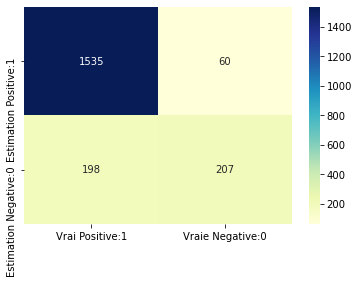

>> resultat de la classification:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1595
           1       0.78      0.51      0.62       405

    accuracy                           0.87      2000
   macro avg       0.83      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000

Justesse de la Classification (accuracy) : 0.8710
Erreurs de Classification : 0.1290
Recall ou Sensitivity : 0.8857
taux de faux positive:
0.2247191011235955
False Positive Rate : 0.2247
Specificity : 0.7753


In [38]:
classif_result(y_test,y_pred_bmd).cm()